### Simulation Generator

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad
import scipy.integrate as integrate
import numpy as np
import random
import tqdm
import pickle
import torch
import torch.optim as optim
import torch.nn as nn
import random
# for plot and stimulate
def simulate_squid_game_v2(L, N, p, T):
    """
    Simulate the Squid Game scenario for T turns.
    
    Parameters:
    - L (int): Max number of players that can be sent back to the start line
    - N (int): Total number of players
    - p (list): List of N probabilities of failing to freeze for each player
    - T (int): Number of turns to simulate
    
    Returns:
    dict: A dictionary where the keys are player indices and the values are dictionaries.
          The inner dictionaries have keys as positions and values as the probability of 
          each player being in that position after T turns.
    """
    # Initialize players' positions
    positions = np.zeros(N, dtype=int)
    
    # Store the history of each player's position
    history = np.zeros((N, T+1), dtype=int)
    
    # Simulate the game for T turns
    for t in range(T):
        # Move all players one step forward
        positions += 1
        
        # Determine which players failed to freeze
        failed_to_freeze = np.random.rand(N) < p
        
        # If more than L players failed to freeze, find the L players who traveled the farthest
        if np.sum(failed_to_freeze) > L:
            # Find the indices of the L players who traveled the farthest and failed to freeze
            farthest_failed_indices = np.argsort(positions * failed_to_freeze)[-L:]
            
            # Send them back to the starting line
            positions[farthest_failed_indices] = 0
        else:
            # Send all players who failed to freeze back to the starting line
            positions[failed_to_freeze] = 0
        
        # Update history
        history[:, t+1] = positions
        
    # Calculate the probability distributions for each player
    prob_distributions = {}
    for i in range(N):
        # Count occurrences of each position and divide by T to get probabilities
        unique, counts = np.unique(history[i, :], return_counts=True)
        prob_distributions[i] = dict(zip(unique, counts))
    
    return prob_distributions

def plot_simulation_vs_estimate(p, result, probabilities_estimated, people_order=0,T=1000000):
    """
    Plot the simulated and estimated probabilities along with their relative error.
    
    Parameters:
    - result (dict): Output from the simulate_squid_game_v2 function
    - p (list): List of N probabilities of failing to freeze for each player
    
    Returns:
    None
    """
    # Extract position probabilities for player 0 from simulation
    #probabilities_estimated*=T
    positions_simulated = list(result[people_order].keys())
    probabilities_simulated = list(result[people_order].values())
    probabilities_simulated = np.array(probabilities_simulated)/sum(probabilities_simulated)
    

    # Estimate probabilities for the same positions
    #probabilities_estimated = [estimate(p[people_order], k) for k in positions_simulated]

    # Calculate relative errors
    rel_errors = [abs(est - sim) / sim for est, sim in zip(probabilities_estimated, probabilities_simulated)]

    # Create plots
    plt.figure(figsize=(15, 5))

    # Plot probabilities
    plt.subplot(1, 2, 1)
    plt.plot(positions_simulated, probabilities_simulated, label='Simulated')
    plt.plot(positions_simulated, probabilities_estimated, label='Estimated', linestyle='--')
    plt.xlabel(f"Position (k), p={p[people_order]}")
    plt.ylabel('Probability')
    plt.title('Probabilities: Simulated vs. Estimated')
    plt.legend()

    # Plot relative errors
    plt.subplot(1, 2, 2)
    plt.plot(positions_simulated, rel_errors, label='Rel. Error', color='red')
    plt.xlabel(f"Position (k), p={p[people_order]}")
    plt.ylabel('Relative Error')
    plt.title('Relative Error: Simulated vs. Estimated')
    plt.legend()

    # Display plots
    plt.tight_layout()
    plt.show()
def gaussian_weighted_sums(data, mu, sigma):
    """
    This function calculates the gaussian weighted sum for elements in the data
    less than and greater than the mean (mu).

    Parameters:
    data (list of float): The list of data points.
    mu (float): The mean of the gaussian distribution.
    sigma (float): The standard deviation of the gaussian distribution.

    Returns:
    tuple: (sum_less_than_mu, sum_greater_than_mu)
    """
    sum_less_than_mu = 0
    sum_near_mu = 0
    sum_greater_than_mu = 0
    

    # Calculate the gaussian weighted sum
    for p in data:
        weight = norm.pdf(p, mu, sigma)
        if p < mu - 0.5*sigma:
            sum_less_than_mu += weight
        elif p > mu + 0.5*sigma:
            sum_greater_than_mu += weight
        else:
            sum_near_mu += weight
    sum_less_than_mu /= len(data)
    sum_near_mu /= len(data)
    sum_greater_than_mu /= len(data)
    return [sum_less_than_mu, sum_near_mu, sum_greater_than_mu]
def square_weighted_sums(data, mu, power):
    """
    This function calculates the gaussian weighted sum for elements in the data
    less than and greater than the mean (mu).

    Parameters:
    data (list of float): The list of data points.
    mu (float): The mean of the gaussian distribution.
    sigma (float): The standard deviation of the gaussian distribution.

    Returns:
    tuple: (sum_less_than_mu, sum_greater_than_mu)
    """
    sum_less_than_mu = 0
    sum_greater_than_mu = 0

    # Calculate the gaussian weighted sum
    for p in data:
        weight = (abs(p-mu))**power
        if p < mu:
            sum_less_than_mu += weight
        elif p > mu:
            sum_greater_than_mu += weight
    sum_less_than_mu /= len(data)
    sum_greater_than_mu /= len(data)
    return [sum_less_than_mu, sum_greater_than_mu]

def generate_input_data(data,p):
    # 59
    output=[]
    sigma_list = [p/20,p/15,p/10,p/8,p/4,p/2,p,2*p,4*p,8*p,16*p,32*p,0.001,0.002,0.004,0.008,0.016,0.032,0.064,0.128,0.256]
    power_list = [1/20,1/15,1/10,1/8,1/4,1/2,1,1.1,1.2,1,4,1.8,2,2.4,3,3.5,4]
    for sigma in sigma_list:
        output+=gaussian_weighted_sums(data,0,sigma)
    for power in power_list:
        output+=square_weighted_sums(data,0,power)
    return output#,len(sigma_list)*3+len(power_list)*2
def count_ranges(data, n=100):
    counts = [0] * n

    for number in data:
        if 0 <= number < 1:
            index = int(number * n)
            counts[index] += 1

    # 将 counts 转换为浮点数数组
    counts = np.array(counts, dtype=float)

    # 确保不会发生除以零的错误
    total = sum(counts)
    if total != 0:
        counts /= total

    return list(counts)
def solve_for_b(y1, y2, p):
    """
    根据新的等式解出逻辑斯蒂方程中的b参数。
    使用 (1-p)**b = 2 * y1 / y2 - 1 来解出 b。
    """
    return np.log(2 * y1 / y2 - 1) / np.log(1 - p)

def logistic_params(x_list, y_list, p):
    """
    根据特定条件解出逻辑斯蒂方程的参数a, b, c。
    """
    # 寻找y值最接近0.5*y_list[0]对应的x_middle
    half_y0 = 0.5 * y_list[0]
    x_middle = x_list[np.abs(y_list - half_y0).argmin()]

    # 情况1
    if y_list[1] / y_list[0] > 0.99:
        a = y_list[0]
        c = x_middle
        # 确保x_middle + 1不超出范围
        if x_middle + 1 < len(x_list):
            b = solve_for_b(y_list[x_middle], y_list[x_middle + 1], p)
        else:
            # 如果x_middle是最后一个元素，则使用x_middle和x_middle - 1
            b = solve_for_b(y_list[x_middle - 1], y_list[x_middle], p)
        print("case 1")
    else:
        # 情况2: 找出y_list[i] - y_list[i + 1]差值最大的i，使用绝对差值
        diff = np.abs(np.diff(y_list))
        i_max_diff = np.argmax(diff)
        print(i_max_diff)
        a = 2 * y_list[i_max_diff]
        c = x_list[i_max_diff]
        b = solve_for_b(y_list[i_max_diff], y_list[i_max_diff + 1], p)
        print("case 2")

    return a, b, c
def method_3_2(N,L,p_list,people_order,judge=None,T=100000):
    if judge==None:
        judge=N/L-1
    p=p_list
    p0=p_list[people_order]

    result= simulate_squid_game_v2(L, N, p, T)
    positions_simulated = list(result[people_order].keys())


    def estiminate(x, judge, p):
        middle = p * (1 - p)**judge
        double_middle = 2 * middle
        
        # 使用NumPy的向量化操作来处理数组x
        result = np.where(x < judge, double_middle - p * (1 - p)**(2*judge - x), p * (1 - p)**x)
        
        return result/sum(result)
        
    estiminate_num=estiminate(np.array(positions_simulated),judge,p0)
    #print(estiminate_num)
    plot_simulation_vs_estimate(p, result, estiminate_num, people_order=people_order,T=T)


### Net

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define custom layer for ln(x) operation
class CustomLogLayer(nn.Module):
    def forward(self, x):
        # Applying ln(x) for x > 0, else -10
        return torch.where(x > 0, torch.log(x), torch.full_like(x, -10.0))

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        # Define layers for path 1
        self.dense1_path1 = nn.Linear(107, 500)
        self.custom_log_layer = CustomLogLayer()
        #self.combine_dense=nn.Linear(3103, 3000)
        self.dense2_path1 = nn.Linear(500, 500)
        #self.dense3_path1 = nn.Linear(1500, 1500)
        #self.combine_dense=nn.Linear(3000, 3000)

        # Define layer for path 2
        self.dense_path2 = nn.Linear(107, 500)

        # Define layers after concatenation
        self.dense1_combined = nn.Linear(1000, 2000)
        self.dense2_combined = nn.Linear(2000, 1000)
        self.dense3_combined = nn.Linear(1000, 500)
        self.dense4_combined = nn.Linear(500, 100)
        self.dense5_combined = nn.Linear(100, 1)
        # self.dense6_combined = nn.Linear(24, 50)
        # self.dense7_combined = nn.Linear(50, 1)

    def forward(self, x):
        # Path 1
        x1 = F.relu(self.dense1_path1(x))
        x1 = self.custom_log_layer(x1)
        #x1 = torch.cat([x1, x], dim=0)
        #x1 = self.combine_dense(x1)
        x1 = torch.exp(self.dense2_path1(x1))
        x1 = torch.pow(x1, 1/4)

        

        # Path 2
        x2 = F.relu(self.dense_path2(x))
        #x2 = x


        # Concatenate
        combined = torch.cat([x1, x2], dim=0)

        # Path 3
        x3=x[:4]

        # Further layers
        combined = F.relu(self.dense1_combined(combined))
        combined = F.relu(self.dense2_combined(combined))
        combined = F.relu(self.dense3_combined(combined))
        combined = F.relu(self.dense4_combined(combined))
        output = self.dense5_combined(combined)

        return output

### Load Net (Net was generated by another file)

In [3]:
# torch.save(model.state_dict(), 'model_sample2.pth')
model=MyNetwork().double()
state_dict= torch.load('model_sample2.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

### Validation with Diagram

In [4]:
def method_for_part_b(N,L,p_list,people_order,T=100000):
    #result=simulate_squid_game_v2(L, N, p_list, T)
    p = p_list[people_order]
    data_list = generate_input_data(p_list, p)
    #lin_list=count_ranges(p_list, n=100)
    mu=np.mean(p_list)

    data_list=[1/p]+[p]+[L/N]+[N/L-1]+[N*p/L]+[L/N/p]+[mu]+[1/mu]+[mu*N/L]+[L/N/mu]+data_list
    with torch.no_grad(): 
        data_tensor = torch.tensor(data_list, dtype=torch.double)
        predicted = model(data_tensor)
    print(predicted)
    method_3_2(N,L,p_list,people_order,judge=float(predicted),T=100000)

tensor([48.0524], dtype=torch.float64)


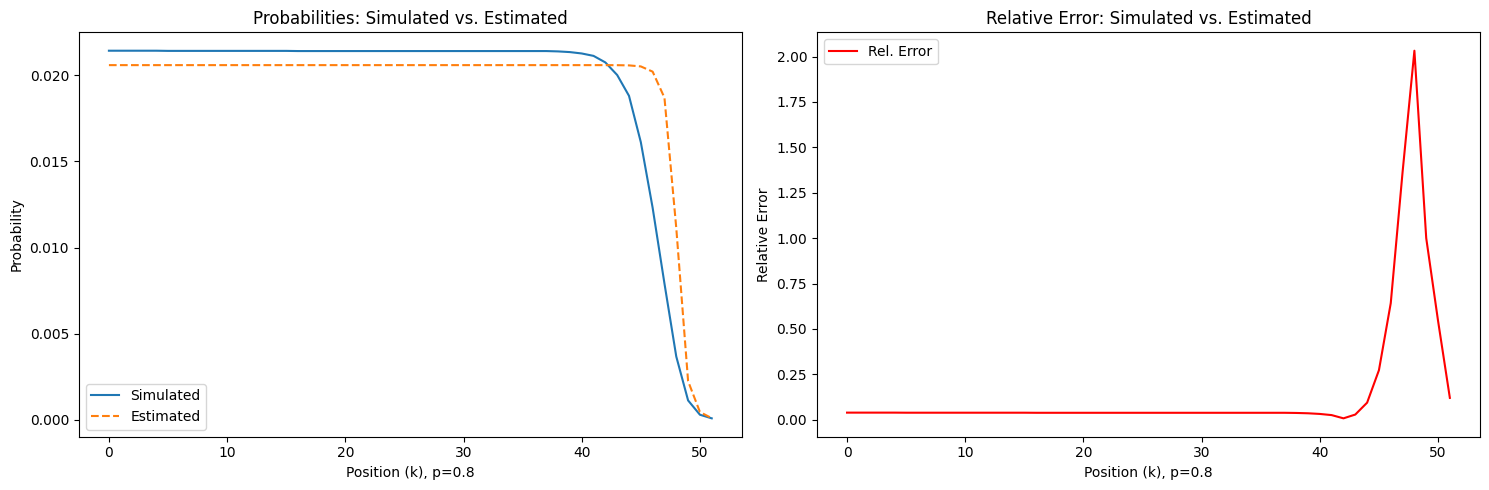

In [7]:
L = 2
N = 100
T = 100000
p_list=[0.1]*10+[0.2]*50+[0.4]*10+[0.8]*30
people_order=70

method_for_part_b(N,L,p_list,people_order,T=T)